<a href="https://colab.research.google.com/github/fazalpge/product_forecasting/blob/main/Multivariate_multiple_timeseries_forecasting_Prophet_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [30]:
class ProphetModel(BaseEstimator, TransformerMixin):
    def __init__(self, periods=90, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, holidays=None):
        """
        Initialize the Prophet model with the specified parameters.
        """
        self.periods = periods
        self.yearly_seasonality = yearly_seasonality
        self.weekly_seasonality = weekly_seasonality
        self.daily_seasonality = daily_seasonality
        self.holidays = holidays
        self.models = {}


    def fit(self, X, y=None):

      """
        Fit the Prophet models for each unique combination of 'Location' and 'ItemName'.
        """

      unique_combinations = X[['Location', 'ItemName']].drop_duplicates()
      for _, row in unique_combinations.iterrows():
          location, item_name = row['Location'], row['ItemName']
          sub_df = self._prepare_data(X, location, item_name)
          if sub_df.dropna().shape[0] >= 2:
              self._fit_model(sub_df, location, item_name)
          else:
              print(f"Skipping combination Location: {location}, ItemName: {item_name} due to insufficient data")
      return self

    def _prepare_data(self, X, location, item_name):
        """
        Prepare the data for a specific location and item name.
        """
        sub_df = X[(X['Location'] == location) & (X['ItemName'] == item_name)].copy()
        sub_df = sub_df.rename(columns={'TransactionDate': 'ds', 'SaleQty': 'y', 'SaleBonusQty': 'bonus_qty'})
        sub_df['ds'] = pd.to_datetime(sub_df['ds'], format='%Y-%m-%d')
        sub_df['bonus_qty'] = sub_df['bonus_qty'].fillna(0)
        return sub_df

    def _fit_model(self, sub_df, location, item_name):
        """
        Fit a Prophet model for the prepared data.
        """
        model = Prophet(
            yearly_seasonality=self.yearly_seasonality,
            weekly_seasonality=self.weekly_seasonality,
            daily_seasonality=self.daily_seasonality,
            holidays=self.holidays
        )
        model.add_regressor('bonus_qty', standardize=False)
        model.fit(sub_df)
        self.models[(location, item_name)] = model

    def transform(self, X, location=None, item_name=None, interval='daily'):
        """
        Generate forecasts for the specified location and item name,
        with optional aggregation by 'daily', 'weekly', or 'monthly'.
        """
        forecast_df = pd.DataFrame()
        data = self._filter_data(X, location, item_name)  # Call the missing method here
        unique_combinations = data[['Location', 'ItemName']].drop_duplicates()

        for _, row in unique_combinations.iterrows():
            loc, itm = row['Location'], row['ItemName']
            if (loc, itm) in self.models:
                forecast_df = pd.concat([forecast_df, self._forecast(loc, itm, data)], ignore_index=True)

        # Aggregate the forecast based on the specified interval
        if interval == 'weekly':
            forecast_df = self._aggregate_forecast(forecast_df, 'W')
        elif interval == 'monthly':
            forecast_df = self._aggregate_forecast(forecast_df, 'ME')
        elif interval == 'half-yearly':
            forecast_df = self._aggregate_forecast(forecast_df, '6ME')
        elif interval == 'yearly':
            forecast_df = self._aggregate_forecast(forecast_df, 'YE')

        return forecast_df

    def _filter_data(self, X, location, item_name):
        """
        Filter the data based on the specified location and item name.
        """
        if location and item_name:
            return X[(X['Location'] == location) & (X['ItemName'] == item_name)]
        if location:
            return X[X['Location'] == location]
        if item_name:
            return X[X['ItemName'] == item_name]
        return X

    def _forecast(self, loc, itm, data):
        """
        Generate forecasts for the specified location and item name.
        """
        forecast_df = pd.DataFrame()
        model = self.models[(loc, itm)]

        # Create future dataframe with default Prophet handling
        future = model.make_future_dataframe(periods=self.periods)  # Default to daily frequency
        future = pd.merge(future, data[['ds', 'bonus_qty']], on='ds', how='left')
        future['bonus_qty'] = future['bonus_qty'].fillna(0)
        forecast = model.predict(future)

        # Add metadata for location and item name
        forecast['Location'] = loc
        forecast['ItemName'] = itm
        forecast_df = pd.concat([forecast_df, forecast], ignore_index=True)

        return forecast_df

    def _aggregate_forecast(self, forecast_df, freq):
        """
        Aggregate the forecast data to the specified frequency (weekly, monthly, yearly).
        """
        forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
        aggregated_df = forecast_df.resample(freq, on='ds').agg({
            'yhat': 'sum',
            'yhat_lower': 'sum',
            'yhat_upper': 'sum',
            'Location': 'first',
            'ItemName': 'first'
        }).reset_index()
        return aggregated_df

    def plot_forecast(self, forecast_df, location=None, item_name=None):
        """
        Plot the forecast for the specified location and item name.
        """
        if location and item_name:
            forecast_df = forecast_df[(forecast_df['Location'] == location) & (forecast_df['ItemName'] == item_name)]
        elif location:
            forecast_df = forecast_df[forecast_df['Location'] == location]
        elif item_name:
            forecast_df = forecast_df[forecast_df['ItemName'] == item_name]

        plt.figure(figsize=(10, 6))
        plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Forecast')
        plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], forecast_df['yhat_upper'], color='gray', alpha=0.2)
        plt.title(f'Forecast for {location} - {item_name}')
        plt.xlabel('Date')
        plt.ylabel('SaleQty')
        plt.legend()
        plt.show()

        # Visualize the forecast using Prophet's built-in plotting
        model = self.models.get((location, item_name))
        if model:
            model.plot(forecast_df);  # Add semi-colon to remove duplicated chart
            plt.title(f'Forecast for {location} - {item_name}')
            plt.show()
            model.plot_components(forecast_df)

    def evaluate_model(self, X, location, item_name):
        """
        Evaluate model performance using MAE and MAPE for a specific location and item name.
        """
        # Prepare data using the _prepare_data method
        sub_df = self._prepare_data(X, location, item_name).drop_duplicates(subset='ds')

        # Check if sub_df is empty and return an error if it is
        if sub_df.empty:
            print(f"No data available for Location: {location}, ItemName: {item_name}. Cannot evaluate the model.")
            return

        print(f"Data found for Location: {location}, ItemName: {item_name}. Proceeding with evaluation...")

        # Retrieve the forecast data for the specified location and item name, restricting it to the actual dates
        forecast_df = self._forecast(location, item_name, sub_df)

        # Check if forecast_df is empty
        if forecast_df.empty:
            print(f"No forecast available for Location: {location}, ItemName: {item_name}. Cannot evaluate the model.")
            return

        print(f"Forecast available for Location: {location}, ItemName: {item_name}. Proceeding with merging...")

        # Use only the dates in the actual data (sub_df) for the forecast
        actual_dates = sub_df['ds'].unique()
        forecast_df = forecast_df[forecast_df['ds'].isin(actual_dates)]

        # Merge using the common dates
        performance = pd.merge(
            sub_df[['ds', 'y']],  # Use the actual data from sub_df
            forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],  # Forecast data, now restricted to actual dates
            on='ds', how='inner'  # Use an inner join to focus only on common dates
        )

        if performance.empty:
            print("No matching dates found between actual data and forecast. Exiting evaluation.")
            return

        print("Merged performance data:")
        print(performance.head())

        # Calculate and print MAE
        performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
        print(f'The MAE for the model is {performance_MAE}')

        # Modified MAPE to handle zero or near-zero values
        performance['y'] = performance['y'].replace(0, np.nan)  # Avoid division by zero in MAPE
        performance_MAPE = np.mean(np.abs((performance['y'] - performance['yhat']) / performance['y'])) * 100
        print(f'The MAPE for the model is {performance_MAPE}')











In [15]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/fazalpge/product_forecasting/main/Inventory%20Data_fazal.csv')


In [16]:
df.head()

,TransactionDate,Location,ItemName,Cost,SaleQty,SaleBonusQty,SaleTotalQty,MRP,SaleAmount,PerInvoiceAverageAmount
0,25-Oct-23,Brahmaputra,Clean 100ml,250,50,4,54,940,47000,44439.81
1,25-Oct-23,Brahmaputra,Clean 100ml,250,10,0,10,940,9400,12013.21
2,22-Oct-23,Brahmaputra,Clean 100ml,250,20,1,21,940,18800,92327.94
3,21-Oct-23,Brahmaputra,Clean 100ml,250,6,0,6,940,5640,16732.52
4,19-Oct-23,Brahmaputra,Clean 100ml,250,20,1,21,940,18800,11170.89


In [6]:
df.isnull().sum()

,0
TransactionDate,0
Location,0
ItemName,0
Cost,0
SaleQty,0
SaleBonusQty,0
SaleTotalQty,0
MRP,0
SaleAmount,0
PerInvoiceAverageAmount,0


In [7]:
df_corr=df.drop(columns=["TransactionDate", "Location", "ItemName"])
df_corr.head()

,Cost,SaleQty,SaleBonusQty,SaleTotalQty,MRP,SaleAmount,PerInvoiceAverageAmount
0,250,50,4,54,940,47000,44439.81
1,250,10,0,10,940,9400,12013.21
2,250,20,1,21,940,18800,92327.94
3,250,6,0,6,940,5640,16732.52
4,250,20,1,21,940,18800,11170.89


In [8]:
# Check correlation
df_corr.corrwith(df["SaleQty"])

,0
Cost,0.080651
SaleQty,1.000000
SaleBonusQty,0.791168
SaleTotalQty,0.997913
MRP,-0.166450
SaleAmount,0.856238
PerInvoiceAverageAmount,0.206711


In [17]:
# Ensure the date column is in datetime format
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%d-%b-%y')
df.head()

,TransactionDate,Location,ItemName,Cost,SaleQty,SaleBonusQty,SaleTotalQty,MRP,SaleAmount,PerInvoiceAverageAmount
0,2023-10-25,Brahmaputra,Clean 100ml,250,50,4,54,940,47000,44439.81
1,2023-10-25,Brahmaputra,Clean 100ml,250,10,0,10,940,9400,12013.21
2,2023-10-22,Brahmaputra,Clean 100ml,250,20,1,21,940,18800,92327.94
3,2023-10-21,Brahmaputra,Clean 100ml,250,6,0,6,940,5640,16732.52
4,2023-10-19,Brahmaputra,Clean 100ml,250,20,1,21,940,18800,11170.89


In [18]:
# Rename 'TransactionDate' to 'ds' and 'SaleBonusQty' to 'bonus_qty' for consistency
df = df.rename(columns={'TransactionDate': 'ds', 'SaleQty': 'y', 'SaleBonusQty': 'bonus_qty'})

In [19]:
duplicates = df[df.duplicated(subset=['Location', 'ItemName', 'ds'], keep=False)]
print(duplicates)

             ds     Location     ItemName  Cost    y  bonus_qty  SaleTotalQty  \
0    2023-10-25  Brahmaputra  Clean 100ml   250   50          4            54   
1    2023-10-25  Brahmaputra  Clean 100ml   250   10          0            10   
5    2023-10-16  Brahmaputra  Clean 100ml   250  100         10           110   
6    2023-10-16  Brahmaputra  Clean 100ml   250   20          1            21   
11   2023-09-27  Brahmaputra  Clean 100ml   250   16          0            16   
...         ...          ...          ...   ...  ...        ...           ...   
1802 2022-04-23        Turag  Clean 100ml   250   60          5            65   
1803 2022-11-24        Turag  Clean 100ml     1    0          0             0   
1804 2022-04-23        Turag  Clean 100ml   250   20          1            21   
1805 2022-04-22        Turag  Clean 100ml     1   28          0            28   
1806 2022-04-22        Turag  Clean 100ml     1   60          5            65   

      MRP  SaleAmount  PerI

In [21]:
df = df.groupby(['Location', 'ItemName', 'ds'], as_index=False).agg({
    'y': 'sum',  # or 'mean' depending on how you want to aggregate
    'bonus_qty': 'sum'
})
print(df)

         Location     ItemName         ds    y  bonus_qty
0     Brahmaputra  Clean 100ml 2022-04-23  142          8
1     Brahmaputra  Clean 100ml 2022-04-25   10          0
2     Brahmaputra  Clean 100ml 2022-04-26  343         26
3     Brahmaputra  Clean 100ml 2022-04-27    1          0
4     Brahmaputra  Clean 100ml 2022-07-26  141         13
...           ...          ...        ...  ...        ...
1181        Turag  Clean 100ml 2023-09-20   45          3
1182        Turag  Clean 100ml 2023-10-01   41          2
1183        Turag  Clean 100ml 2023-10-03  200         24
1184        Turag  Clean 100ml 2023-10-04   45          3
1185        Turag  Clean 100ml 2023-10-22  100          8

[1186 rows x 5 columns]


In [24]:
# Define holidays
holidays = pd.DataFrame({
    'holiday': 'bangladesh_holiday',
    'ds': pd.to_datetime([
        '2022-02-21',  # Language Movement Day
        '2022-03-26',  # Independence Day
        '2022-04-14',  # Bengali New Year
        '2022-05-01',  # May Day
        '2022-08-15',  # National Mourning Day
        '2022-12-16',  # Victory Day
        '2023-02-21',  # Language Movement Day
        '2023-03-26',  # Independence Day
        '2023-04-14',  # Bengali New Year
        '2023-05-01',  # May Day
        '2023-08-15',  # National Mourning Day
        '2023-12-16',  # Victory Day

    ]),
    'lower_window': 0,
    'upper_window': 1,
})

In [31]:
# Create a pipeline
pipeline= Pipeline([
    ('prophet', ProphetModel(
        periods=90,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        holidays=holidays
    ))
])

In [ ]:
pipeline

Pipeline(steps=[('prophet',
                 ProphetModel(holidays=              holiday         ds  lower_window  upper_window
0  bangladesh_holiday 2023-02-21             0             1
1  bangladesh_holiday 2023-03-26             0             1
2  bangladesh_holiday 2023-04-14             0             1
3  bangladesh_holiday 2023-05-01             0             1
4  bangladesh_holiday 2023-08-15             0             1
5  bangladesh_holiday 2023-12-16             0             1))])

In [32]:
# Fit the pipeline
pipeline.fit(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/0tezljz2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/ls5m70sf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4051', 'data', 'file=/tmp/tmpv_duy6pf/0tezljz2.json', 'init=/tmp/tmpv_duy6pf/ls5m70sf.json', 'output', 'file=/tmp/tmpv_duy6pf/prophet_modellw0l5jr1/prophet_model-20241017050704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:07:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:07:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 0.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/dt6obahz.json
DEBUG:cmdstanpy:input tempfile: 

Skipping combination Location: Corporate, ItemName: Fresmin F 10kg due to insufficient data


05:07:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/nxdd0nfm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/92x2yu1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87373', 'data', 'file=/tmp/tmpv_duy6pf/nxdd0nfm.json', 'init=/tmp/tmpv_duy6pf/92x2yu1b.json', 'output', 'file=/tmp/tmpv_duy6pf/prophet_modelvsoluq9y/prophet_model-20241017050707.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:07:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Skipping combination Location: Corporate, ItemName: K1 Bio Filter Media due to insufficient data
Skipping combination Location: Corporate, ItemName: Stable Bleaching Powder 25kg due to insufficient data


05:07:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/6uptt6um.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/_lmn_4_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86977', 'data', 'file=/tmp/tmpv_duy6pf/6uptt6um.json', 'init=/tmp/tmpv_duy6pf/_lmn_4_i.json', 'output', 'file=/tmp/tmpv_duy6pf/prophet_model4x0ux2y4/prophet_model-20241017050708.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:07:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Skipping combination Location: Corporate, ItemName: Vivabond (5Ltr.) due to insufficient data


05:07:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/jdffuh4_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/wj9ilzv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67362', 'data', 'file=/tmp/tmpv_duy6pf/jdffuh4_.json', 'init=/tmp/tmpv_duy6pf/wj9ilzv9.json', 'output', 'file=/tmp/tmpv_duy6pf/prophet_modeli4x0cslq/prophet_model-20241017050708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:07:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:07:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/g58gqvm6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/158qs5qx.json
DEBUG:cmdstanpy:idx

Skipping combination Location: Karnaphuli, ItemName: Salivet 1ltr due to insufficient data
Skipping combination Location: Karnaphuli, ItemName: Salivet 500ml due to insufficient data
Skipping combination Location: Karnaphuli, ItemName: Viusid Vet 500ml due to insufficient data


05:07:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/9wx48l86.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/v5n9q3n3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44019', 'data', 'file=/tmp/tmpv_duy6pf/9wx48l86.json', 'init=/tmp/tmpv_duy6pf/v5n9q3n3.json', 'output', 'file=/tmp/tmpv_duy6pf/prophet_modelq9ewsxci/prophet_model-20241017050712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:07:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:07:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/e1s1_kei.json
DEBUG:cm

Skipping combination Location: Kopotakkho, ItemName: Gentech - P.S (20 LTr.) due to insufficient data


05:07:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/am1x9lls.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/ye4pcwlr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81111', 'data', 'file=/tmp/tmpv_duy6pf/am1x9lls.json', 'init=/tmp/tmpv_duy6pf/ye4pcwlr.json', 'output', 'file=/tmp/tmpv_duy6pf/prophet_modelbn21w6kz/prophet_model-20241017050721.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:07:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Skipping combination Location: Muhuri, ItemName: Fresmin F 10kg due to insufficient data


05:07:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/w7wwdj6y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/nabrxgi0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91331', 'data', 'file=/tmp/tmpv_duy6pf/w7wwdj6y.json', 'init=/tmp/tmpv_duy6pf/nabrxgi0.json', 'output', 'file=/tmp/tmpv_duy6pf/prophet_modelaufigkcf/prophet_model-20241017050723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:07:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:07:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/w78fxb37.json
DEBUG:cm

Skipping combination Location: Padma, ItemName: Fresmin F 10kg due to insufficient data


05:07:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/qklopg6f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/wk501ou4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12339', 'data', 'file=/tmp/tmpv_duy6pf/qklopg6f.json', 'init=/tmp/tmpv_duy6pf/wk501ou4.json', 'output', 'file=/tmp/tmpv_duy6pf/prophet_modell7ibo7wh/prophet_model-20241017050725.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:07:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Skipping combination Location: Padma, ItemName: Vivamin (10kg) due to insufficient data
Skipping combination Location: R&D Center, ItemName: Viusid Aqua 150ml due to insufficient data


05:07:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/4clnosd3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/hlf2jt2j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18507', 'data', 'file=/tmp/tmpv_duy6pf/4clnosd3.json', 'init=/tmp/tmpv_duy6pf/hlf2jt2j.json', 'output', 'file=/tmp/tmpv_duy6pf/prophet_model4nz364oq/prophet_model-20241017050725.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:07:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Skipping combination Location: Rupsha, ItemName: Fresmin F 10kg due to insufficient data


05:07:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/_jd0r6w5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_duy6pf/5h2k17_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43464', 'data', 'file=/tmp/tmpv_duy6pf/_jd0r6w5.json', 'init=/tmp/tmpv_duy6pf/5h2k17_4.json', 'output', 'file=/tmp/tmpv_duy6pf/prophet_modelprk7fs4_/prophet_model-20241017050725.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:07:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:07:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Usin

Skipping combination Location: Tista, ItemName: Fresmin F 10kg due to insufficient data


05:07:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Pipeline(steps=[('prophet',
                 ProphetModel(holidays=               holiday         ds  lower_window  upper_window
0   bangladesh_holiday 2022-02-21             0             1
1   bangladesh_holiday 2022-03-26             0             1
2   bangladesh_holiday 2022-04-14             0             1
3   bangladesh_holiday 2022-05-01             0             1
4   bangladesh_holiday 2022-08-15             0             1
5   bangladesh_holiday 2022-12-16             0             1
6   bangladesh_holiday 2023-02-21             0             1
7   bangladesh_holiday 2023-03-26             0             1
8   bangladesh_holiday 2023-04-14             0             1
9   bangladesh_holiday 2023-05-01             0             1
10  bangladesh_holiday 2023-08-15             0             1
11  bangladesh_holiday 2023-12-16             0             1))])

In [33]:
forecast_df= pipeline.named_steps['prophet'].transform(df, location='Brahmaputra', item_name='Clean 100ml', interval='daily')

print(forecast_df)


            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2022-04-23  46.568625  103.370800  142.162746    46.568625    46.568625   
1   2022-04-25  46.535413   -6.449270   33.058385    46.535413    46.535413   
2   2022-04-26  46.518806  310.906600  350.875451    46.518806    46.518806   
3   2022-04-27  46.502200  -12.953648   25.864244    46.502200    46.502200   
4   2022-07-26  45.007640  141.186292  178.699070    45.007640    45.007640   
..         ...        ...         ...         ...          ...          ...   
189 2024-01-19  36.009510   33.733021   72.264700    36.009476    36.009542   
190 2024-01-20  35.992909  -15.924574   25.330833    35.992874    35.992941   
191 2024-01-21  35.976308  -22.372450   17.957370    35.976272    35.976341   
192 2024-01-22  35.959706  -21.471591   18.505306    35.959671    35.959740   
193 2024-01-23  35.943105  -26.319399   11.664206    35.943069    35.943139   

     additive_terms  additive_terms_lower  additive

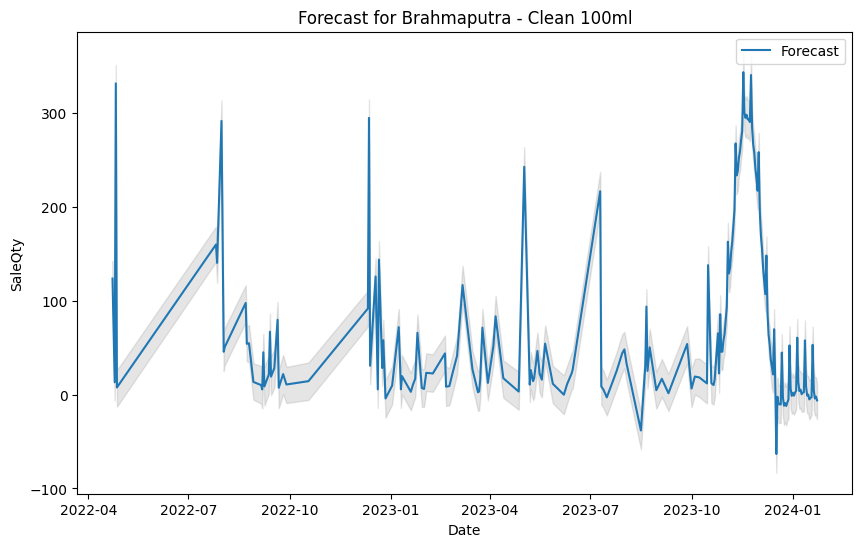

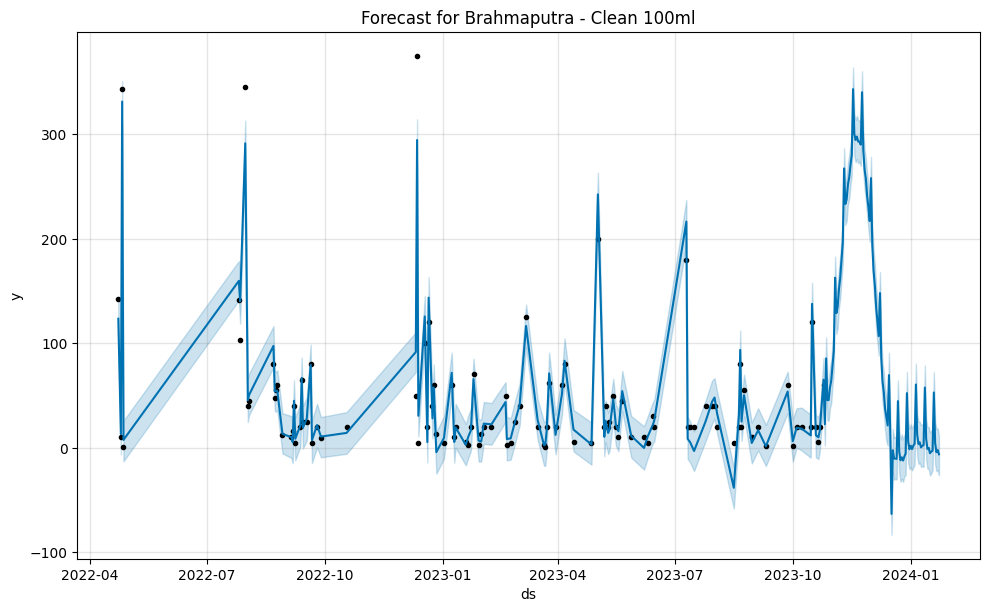

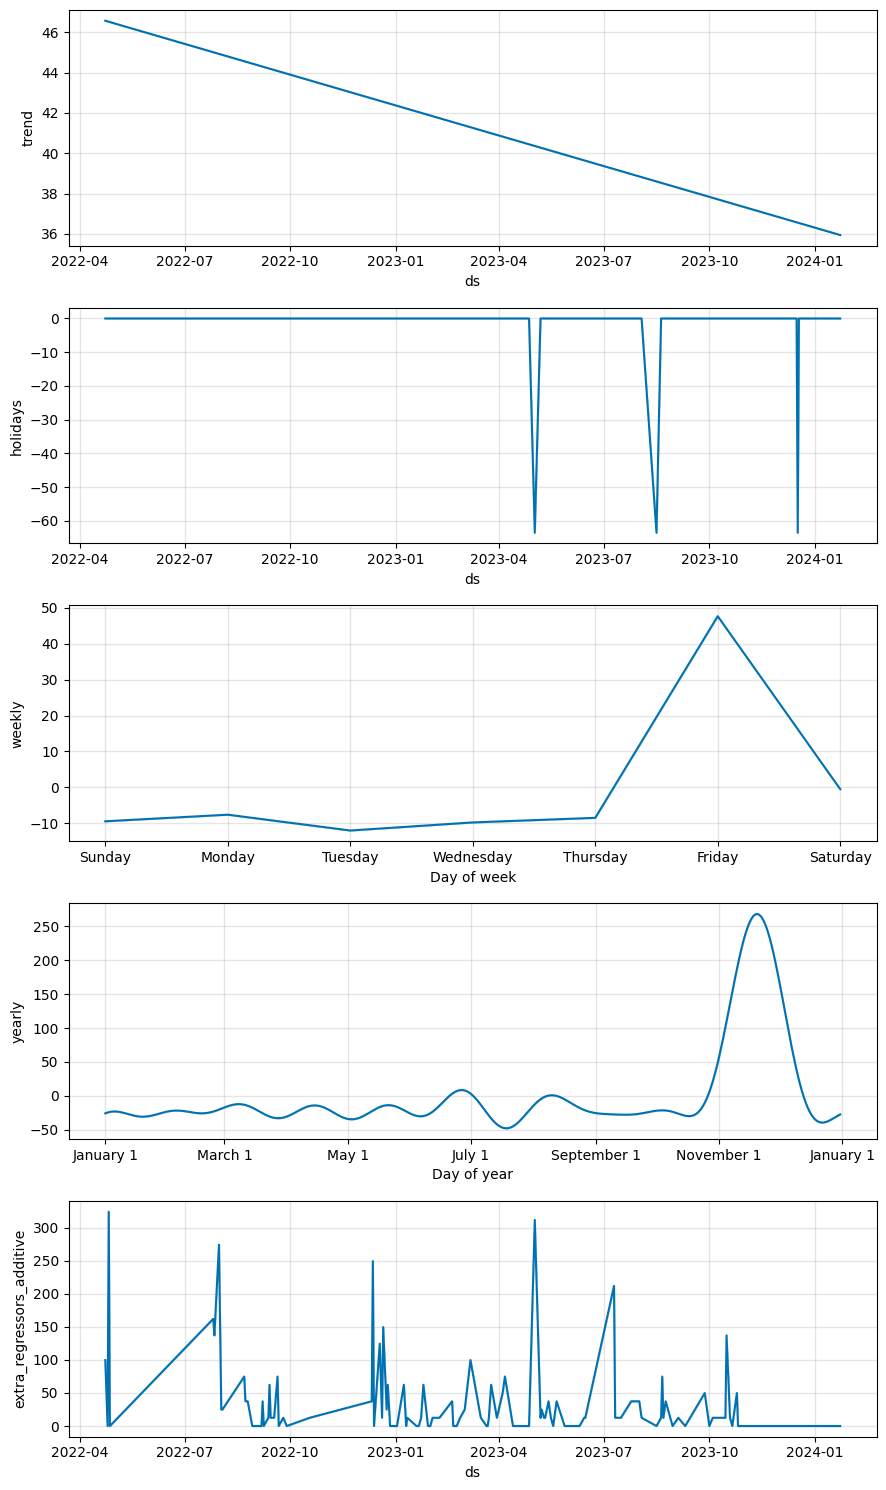

In [34]:
# Example of plotting the forecast for a specific Location and ItemName
pipeline.named_steps['prophet'].plot_forecast(forecast_df, location='Brahmaputra', item_name='Clean 100ml')

In [35]:
#Calling the evaluate_model function:


pipeline.named_steps['prophet'].evaluate_model(df, location='Brahmaputra', item_name='Clean 100ml')

Data found for Location: Brahmaputra, ItemName: Clean 100ml. Proceeding with evaluation...
Forecast available for Location: Brahmaputra, ItemName: Clean 100ml. Proceeding with merging...
Merged performance data:
          ds    y        yhat  yhat_lower  yhat_upper
0 2022-04-23  142  123.484264  104.396320  143.981207
1 2022-04-25   10   13.030145   -6.802836   32.582425
2 2022-04-26  343  331.342421  312.654673  351.696443
3 2022-04-27    1    7.517512  -12.762640   27.711804
4 2022-07-26  141  159.710040  139.407832  178.786677
The MAE for the model is 9.827342727386368
The MAPE for the model is 58.50688359459527


In [ ]:
forecast_df = pipeline.named_steps['prophet'].transform(df, location='Brahmaputra', item_name='Clean 100ml', interval='weekly')



print(forecast_df)


            ds        yhat  yhat_lower  yhat_upper     Location     ItemName
0   2022-04-24  123.484264  104.620936  144.251977  Brahmaputra  Clean 100ml
1   2022-05-01  351.890078  291.413219  410.590001  Brahmaputra  Clean 100ml
2   2022-05-08    0.000000    0.000000    0.000000         None         None
3   2022-05-15    0.000000    0.000000    0.000000         None         None
4   2022-05-22    0.000000    0.000000    0.000000         None         None
..         ...         ...         ...         ...          ...          ...
127 2024-09-29   51.928602  -83.124817  189.360679  Brahmaputra  Clean 100ml
128 2024-10-06   70.189105  -69.968505  209.788270  Brahmaputra  Clean 100ml
129 2024-10-13   46.929911  -93.453660  183.867275  Brahmaputra  Clean 100ml
130 2024-10-20   16.613000 -124.960161  156.241518  Brahmaputra  Clean 100ml
131 2024-10-27    7.877815  -72.795522   86.544813  Brahmaputra  Clean 100ml

[132 rows x 6 columns]


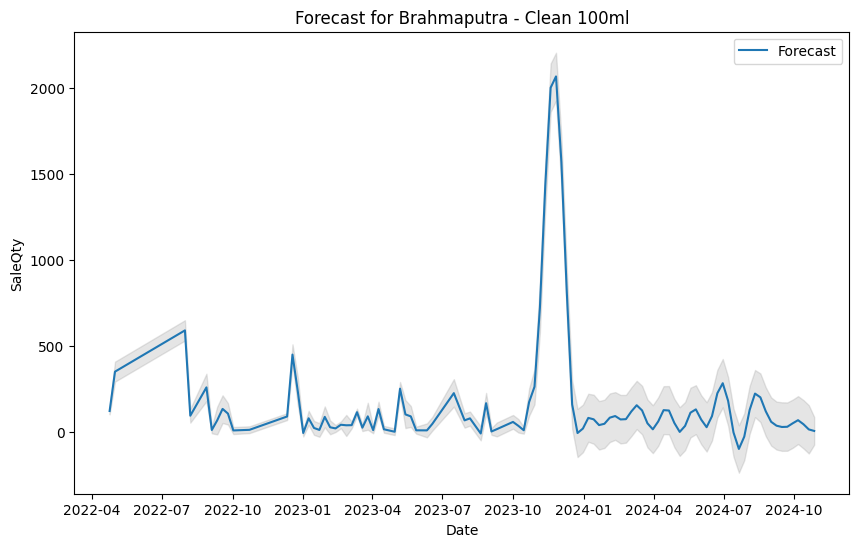

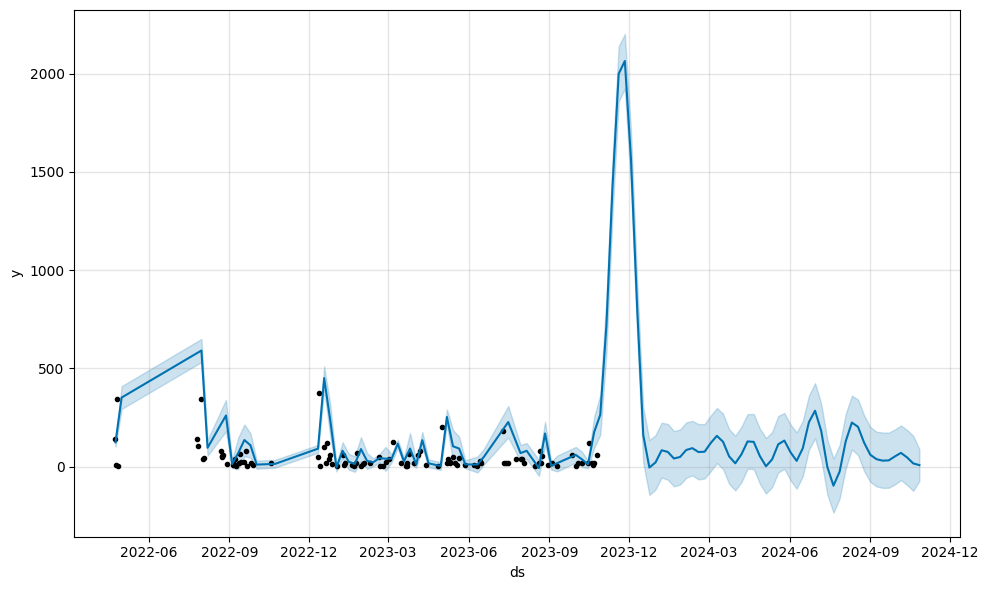

In [ ]:
# Example of plotting the forecast for a specific Location and ItemName
pipeline.named_steps['prophet'].plot_forecast(forecast_df, location='Brahmaputra', item_name='Clean 100ml')

In [ ]:
forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bangladesh_holiday,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,46.568625,102.311971,144.327174,46.568625,46.568625,76.915639,76.915639,76.915639,0.0,...,-0.480113,-22.431948,-22.431948,-22.431948,0.0,0.0,0.0,123.484264,Brahmaputra,Clean 100ml
1,2022-04-25,46.535413,-7.908963,32.773141,46.535413,46.535413,-33.505268,-33.505268,-33.505268,0.0,...,-7.573177,-25.932091,-25.932091,-25.932091,0.0,0.0,0.0,13.030145,Brahmaputra,Clean 100ml
2,2022-04-26,46.518806,310.961644,351.198411,46.518806,46.518806,284.823615,284.823615,284.823615,0.0,...,-11.972937,-27.643473,-27.643473,-27.643473,0.0,0.0,0.0,331.342421,Brahmaputra,Clean 100ml
3,2022-04-27,46.502200,-12.903172,27.759385,46.502200,46.502200,-38.984688,-38.984688,-38.984688,0.0,...,-9.723591,-29.261097,-29.261097,-29.261097,0.0,0.0,0.0,7.517512,Brahmaputra,Clean 100ml
4,2022-07-26,45.007640,140.627300,179.696881,45.007640,45.007640,114.702400,114.702400,114.702400,0.0,...,-11.972937,-35.544675,-35.544675,-35.544675,0.0,0.0,0.0,159.710040,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,2024-10-20,31.444166,-24.702997,14.467565,31.443854,31.444455,-36.835560,-36.835560,-36.835560,0.0,...,-9.406043,-27.429517,-27.429517,-27.429517,0.0,0.0,0.0,-5.391394,Brahmaputra,Clean 100ml
465,2024-10-21,31.427565,-20.659895,19.270758,31.427251,31.427854,-32.860703,-32.860703,-32.860703,0.0,...,-7.573177,-25.287526,-25.287526,-25.287526,0.0,0.0,0.0,-1.433138,Brahmaputra,Clean 100ml
466,2024-10-22,31.410964,-23.753327,16.791665,31.410648,31.411253,-34.327885,-34.327885,-34.327885,0.0,...,-11.972937,-22.354948,-22.354948,-22.354948,0.0,0.0,0.0,-2.916922,Brahmaputra,Clean 100ml
467,2024-10-23,31.394362,-17.999690,23.639504,31.394046,31.394653,-28.278224,-28.278224,-28.278224,0.0,...,-9.723591,-18.554633,-18.554633,-18.554633,0.0,0.0,0.0,3.116138,Brahmaputra,Clean 100ml


In [ ]:
#Calling the evaluate_model function:

pipeline.named_steps['prophet'].evaluate_model(df, forecast_df)

The MAE for the model is 22.23306310330116
The MAPE for the model is 1474787929260675.2


In [ ]:
performance = pd.merge(df, forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-365:], on='ds')
performance

,ds,Location,ItemName,Cost,y,bonus_qty,SaleTotalQty,MRP,SaleAmount,PerInvoiceAverageAmount,yhat,yhat_lower,yhat_upper
0,2023-10-25,Brahmaputra,Clean 100ml,250,50,4,54,940,47000,44439.81,37.306119,10.856970,64.005878
1,2023-10-25,Brahmaputra,Clean 100ml,250,50,4,54,940,47000,44439.81,21.054519,-4.807165,47.374192
2,2023-10-25,Brahmaputra,Clean 100ml,250,10,0,10,940,9400,12013.21,37.306119,10.856970,64.005878
3,2023-10-25,Brahmaputra,Clean 100ml,250,10,0,10,940,9400,12013.21,21.054519,-4.807165,47.374192
4,2023-10-22,Brahmaputra,Clean 100ml,250,20,1,21,940,18800,92327.94,28.895108,4.202658,55.608277
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,2023-09-27,Surma,Clean 100ml,250,46,4,50,940,43240,45167.52,17.260920,-9.182523,43.361730
94,2023-10-15,Tista,Clean 100ml,250,5,0,5,940,4700,9452.39,24.839897,0.329503,48.219159
95,2023-10-22,Turag,Clean 100ml,250,100,8,108,940,94000,96198.85,28.895108,4.202658,55.608277
96,2023-10-04,Turag,Clean 100ml,250,45,3,48,940,42300,58121.87,18.185941,-7.263904,45.098875


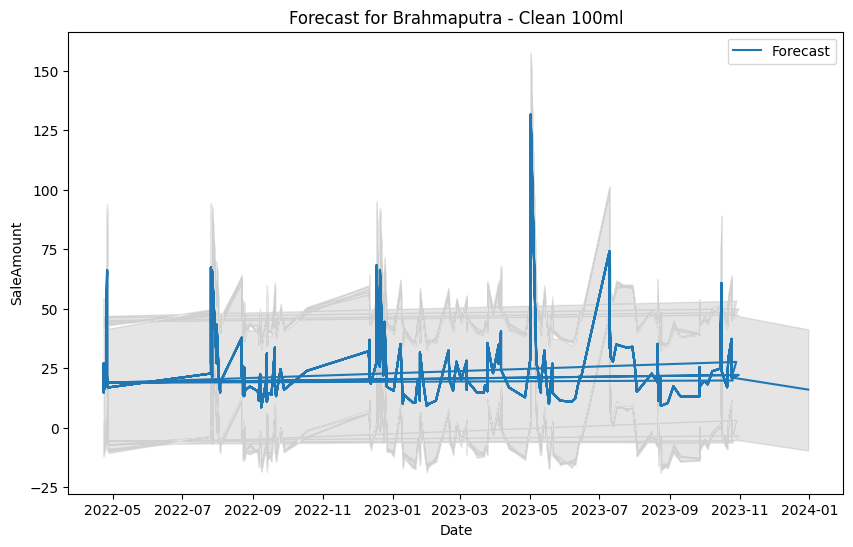

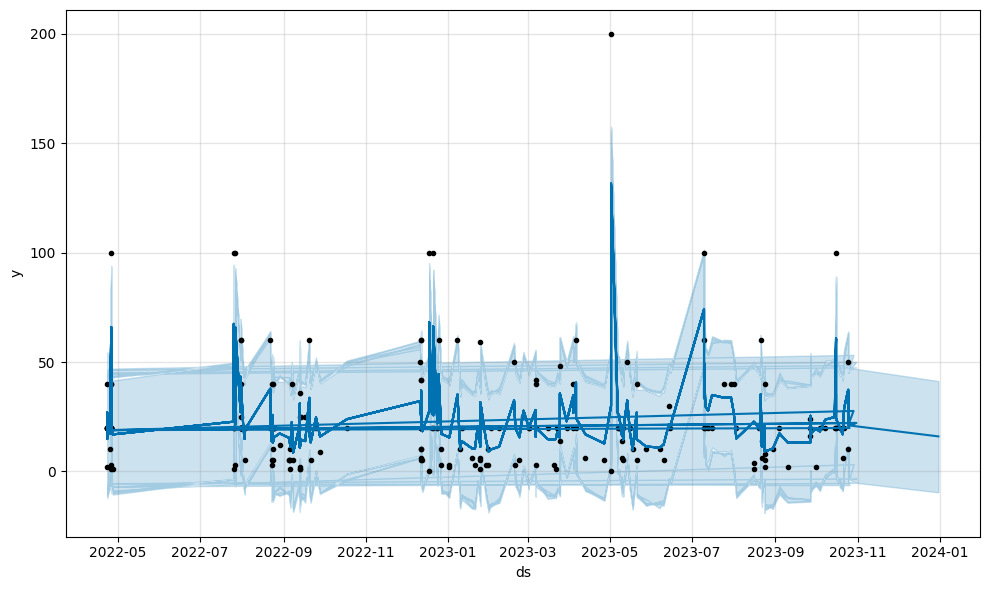

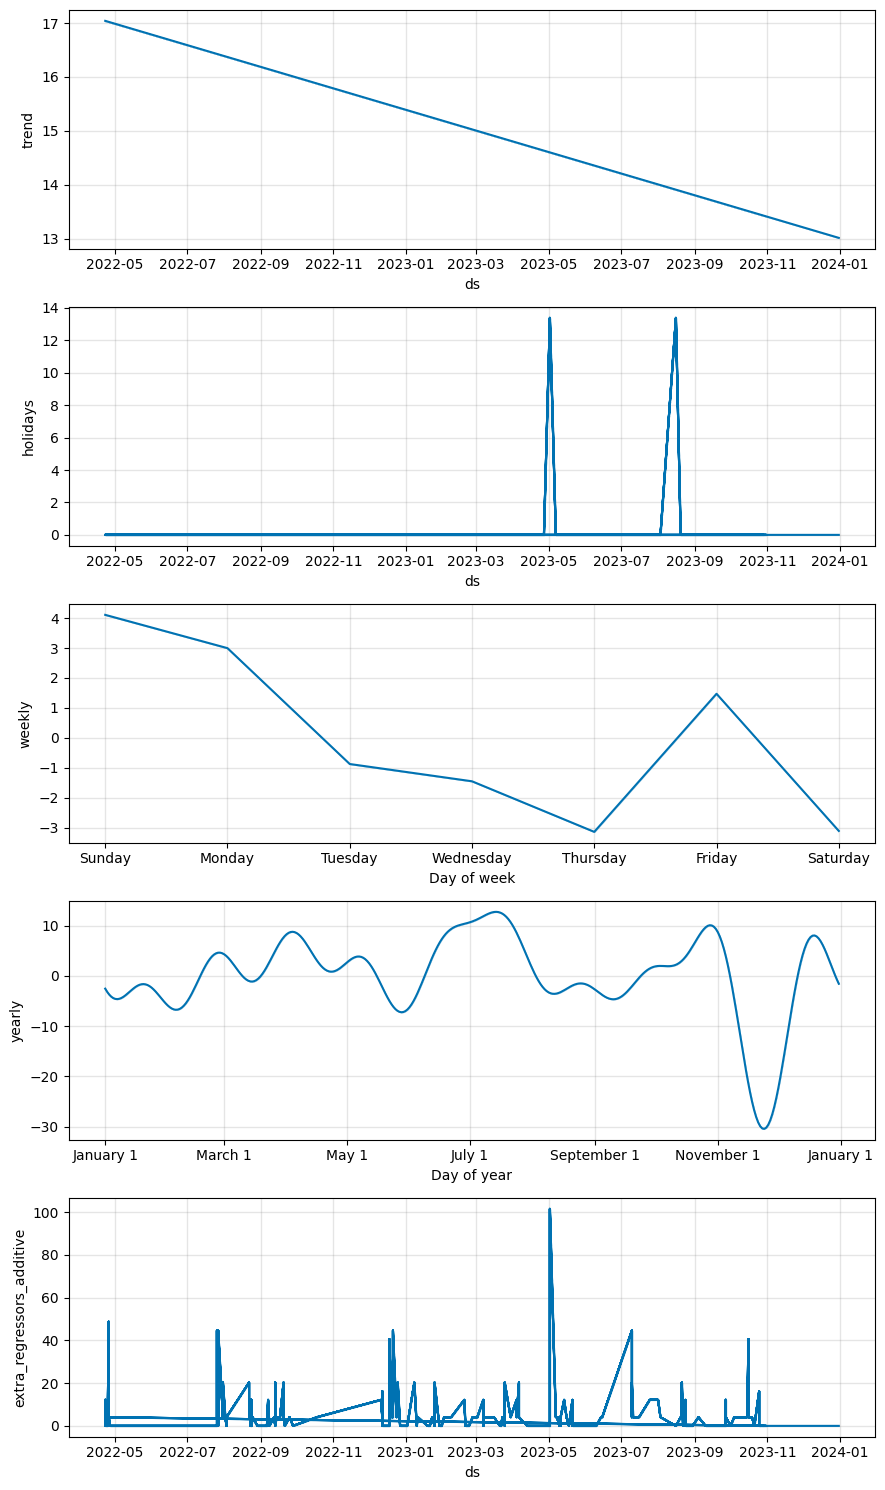

In [ ]:
# Example of plotting the forecast for a specific Location and ItemName
pipeline.named_steps['prophet'].plot_forecast(forecast_df, interval="daily", location='Brahmaputra', item_name='Clean 100ml')

In [ ]:
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'Location',	'ItemName']].tail()

,ds,yhat,yhat_lower,yhat_upper,Location,ItemName
1040,2024-12-31,7499.327093,-16383.604036,33586.951031,Brahmaputra,Clean 100ml
1041,2025-12-31,4913.706681,-20976.388241,27444.506818,Brahmaputra,Clean 100ml
1042,2026-12-31,1287.804284,-25029.109551,24847.115681,Brahmaputra,Clean 100ml
1043,2027-12-31,3592.590368,-20729.362906,29487.733058,Brahmaputra,Clean 100ml
1044,2028-12-31,3226.570760,-22042.169124,27824.117846,Brahmaputra,Clean 100ml


In [ ]:
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'Location',	'ItemName']].head()

,ds,yhat,yhat_lower,yhat_upper,Location,ItemName
0,2022-04-23,17623.541165,-4857.081923,43397.141086,Brahmaputra,Clean 100ml
1,2022-04-23,17623.541165,-7221.743828,40891.414436,Brahmaputra,Clean 100ml
2,2022-04-23,17623.541165,-7179.542614,42328.855364,Brahmaputra,Clean 100ml
3,2022-04-23,17623.541165,-5938.344402,42832.009377,Brahmaputra,Clean 100ml
4,2022-04-23,17623.541165,-5237.642266,43000.241598,Brahmaputra,Clean 100ml


In [ ]:
# Make predictions by calling transform on the ProphetModel directly
forecast_df= pipeline.named_steps['prophet'].transform(df, interval='daily')
forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bangladesh_holiday,...,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName,Interval
0,2022-04-23,16018.201600,-5472.112816,40316.324946,16018.201600,16018.201600,1686.757797,1686.757797,1686.757797,0.0,...,791.035965,791.035965,791.035965,0.0,0.0,0.0,17704.959397,Brahmaputra,Clean 100ml,daily
1,2022-04-23,16018.201600,-5641.876365,41095.187675,16018.201600,16018.201600,1686.757797,1686.757797,1686.757797,0.0,...,791.035965,791.035965,791.035965,0.0,0.0,0.0,17704.959397,Brahmaputra,Clean 100ml,daily
2,2022-04-23,16018.201600,-6787.939333,43460.815255,16018.201600,16018.201600,1686.757797,1686.757797,1686.757797,0.0,...,791.035965,791.035965,791.035965,0.0,0.0,0.0,17704.959397,Brahmaputra,Clean 100ml,daily
3,2022-04-23,16018.201600,-6682.759306,40962.852111,16018.201600,16018.201600,1686.757797,1686.757797,1686.757797,0.0,...,791.035965,791.035965,791.035965,0.0,0.0,0.0,17704.959397,Brahmaputra,Clean 100ml,daily
4,2022-04-23,16018.201600,-5537.708157,42293.990675,16018.201600,16018.201600,1686.757797,1686.757797,1686.757797,0.0,...,791.035965,791.035965,791.035965,0.0,0.0,0.0,17704.959397,Brahmaputra,Clean 100ml,daily
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39573,2023-10-04,18129.930615,10925.054650,62610.283624,18129.930615,18129.930615,18799.708234,18799.708234,18799.708234,0.0,...,-647.812476,-647.812476,-647.812476,0.0,0.0,0.0,36929.638848,Turag,Clean 100ml,yearly
39574,2023-10-22,17940.144409,26794.555937,79084.433778,17940.144409,17940.144409,34088.491865,34088.491865,34088.491865,0.0,...,29463.259199,29463.259199,29463.259199,0.0,0.0,0.0,52028.636274,Turag,Clean 100ml,yearly
39575,2023-10-22,17940.144409,21556.381847,72066.943243,17940.144409,17940.144409,27782.990665,27782.990665,27782.990665,0.0,...,29463.259199,29463.259199,29463.259199,0.0,0.0,0.0,45723.135074,Turag,Clean 100ml,yearly
39576,2023-10-22,17940.144409,71087.370821,121484.184419,17940.144409,17940.144409,78227.000265,78227.000265,78227.000265,0.0,...,29463.259199,29463.259199,29463.259199,0.0,0.0,0.0,96167.144674,Turag,Clean 100ml,yearly


In [ ]:
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'Location',	'ItemName']].tail()

,ds,yhat,yhat_lower,yhat_upper,Location,ItemName
39573,2023-10-04,36929.638848,10925.054650,62610.283624,Turag,Clean 100ml
39574,2023-10-22,52028.636274,26794.555937,79084.433778,Turag,Clean 100ml
39575,2023-10-22,45723.135074,21556.381847,72066.943243,Turag,Clean 100ml
39576,2023-10-22,96167.144674,71087.370821,121484.184419,Turag,Clean 100ml
39577,2023-12-31,13009.989463,-9579.709953,40307.219970,Turag,Clean 100ml


In [ ]:
forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-7643.992760,41698.085192,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,8973.770416,58032.311168,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-9134.325158,37727.138621,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,40498.832183,89328.193380,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,35451.321662,86296.307489,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,2023-11-17,17453.617305,7546.553137,60049.912797,17453.616840,17453.617770,16146.807720,16146.807720,16146.807720,0.000,...,-2778.751462,18925.559181,18925.559181,18925.559181,0.0,0.0,0.0,33600.425024,Turag,Clean 100ml
9876,2023-11-18,17441.357712,1933.724371,53241.970683,17441.357228,17441.358197,10207.432002,10207.432002,10207.432002,0.000,...,-3434.972866,13642.404868,13642.404868,13642.404868,0.0,0.0,0.0,27648.789714,Turag,Clean 100ml
9877,2023-11-19,17429.098120,-1038.702112,48426.678160,17429.097598,17429.098657,6423.816679,6423.816679,6423.816679,0.000,...,-2038.036593,8461.853272,8461.853272,8461.853272,0.0,0.0,0.0,23852.914799,Turag,Clean 100ml
9878,2023-11-20,17416.838527,7285.619860,59020.163993,17416.837977,17416.839087,15070.786713,15070.786713,15070.786713,0.000,...,11615.709702,3455.077012,3455.077012,3455.077012,0.0,0.0,0.0,32487.625240,Turag,Clean 100ml


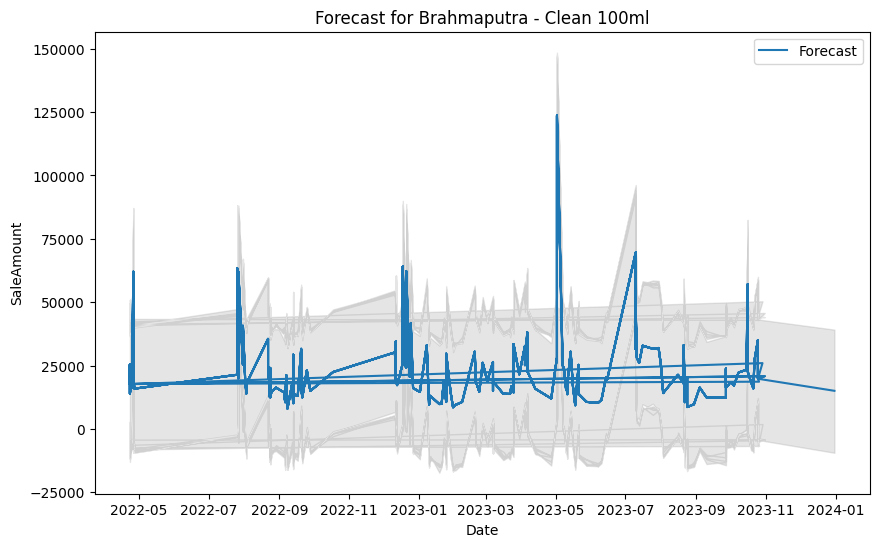

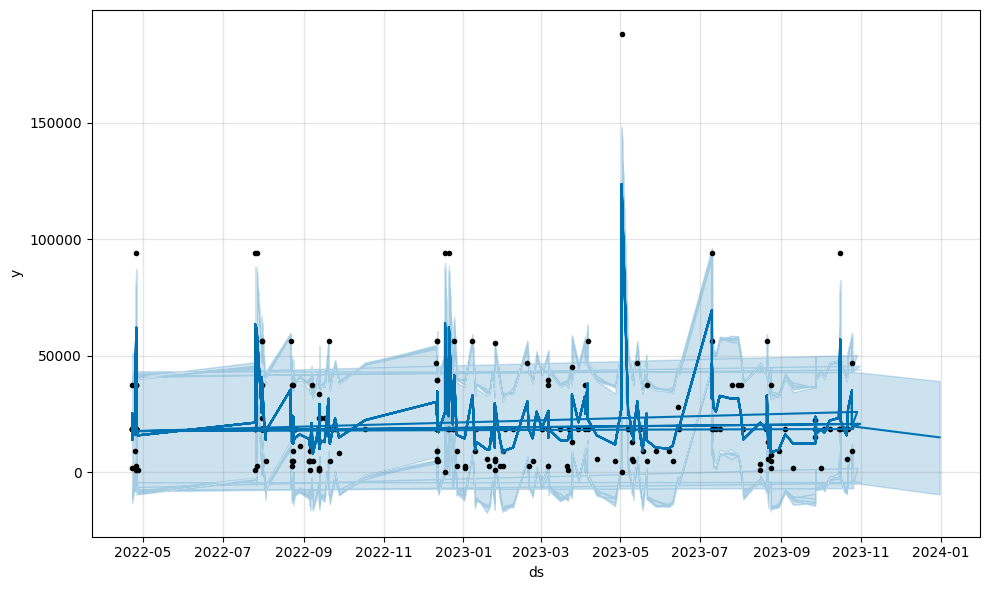

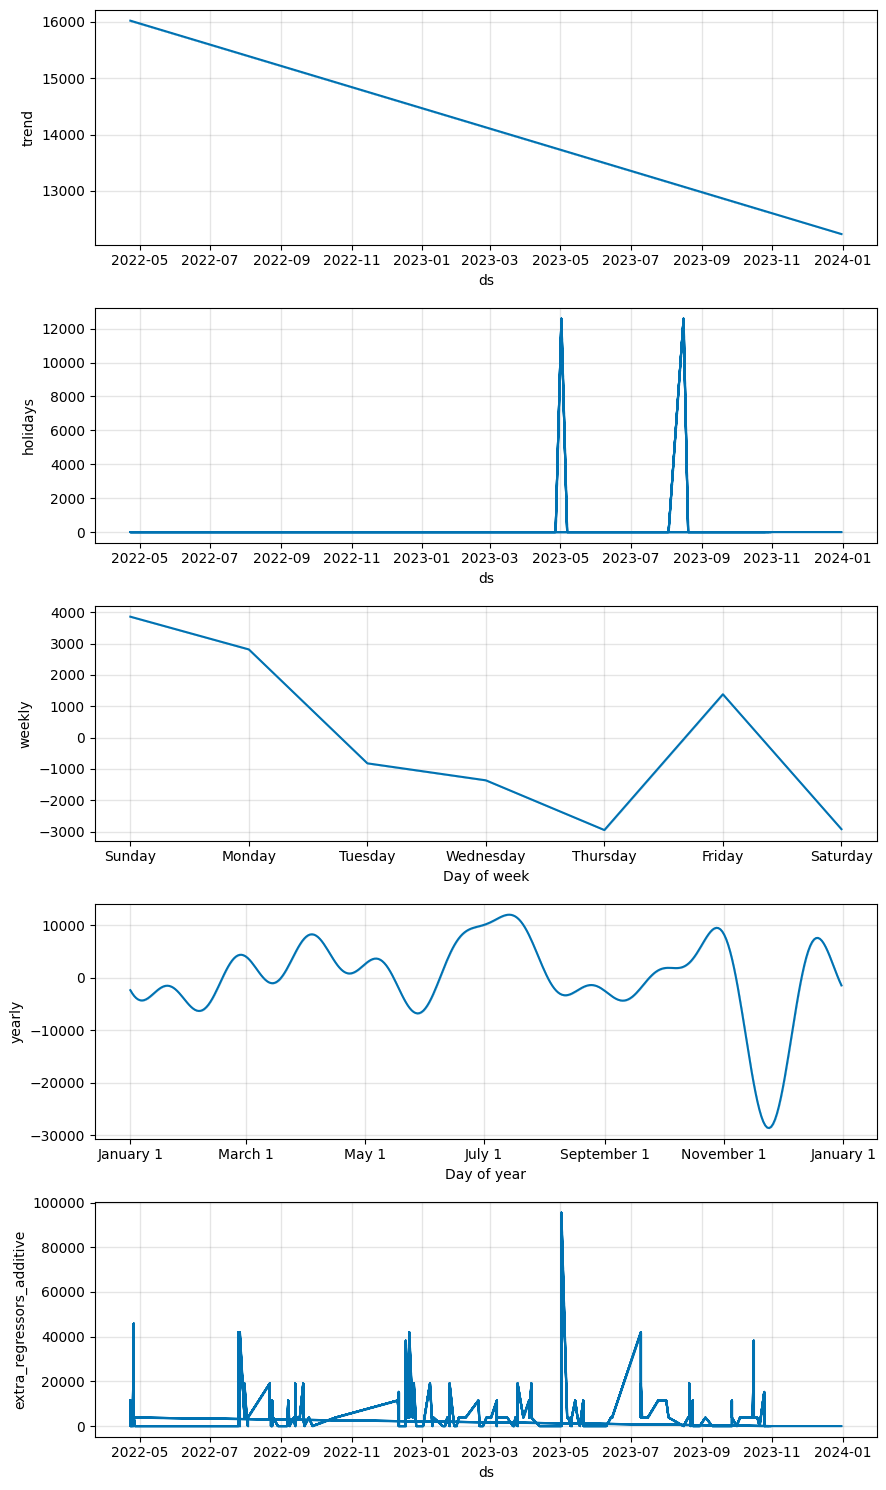

In [ ]:
# Example of plotting the forecast for a specific Location and ItemName
pipeline.named_steps['prophet'].plot_forecast(forecast_df, location='Brahmaputra', item_name='Clean 100ml')

In [ ]:
pipeline.named_steps['prophet'].transform(forecast_df, location='Brahmaputra', item_name='Clean 100ml')

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,1.548354e+07,1.553218e+07,12854.142800,12854.142800,1.549416e+07,1.549416e+07,1.549416e+07,1.549332e+07,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,1.550701e+07,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,1.548287e+07,1.553127e+07,12854.142800,12854.142800,1.549416e+07,1.549416e+07,1.549416e+07,1.549332e+07,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,1.550701e+07,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,1.548339e+07,1.552945e+07,12854.142800,12854.142800,1.549416e+07,1.549416e+07,1.549416e+07,1.549332e+07,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,1.550701e+07,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,1.548334e+07,1.552901e+07,12854.142800,12854.142800,1.549416e+07,1.549416e+07,1.549416e+07,1.549332e+07,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,1.550701e+07,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,1.548423e+07,1.553151e+07,12854.142800,12854.142800,1.549416e+07,1.549416e+07,1.549416e+07,1.549332e+07,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,1.550701e+07,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,2023-11-20,13722.354027,-2.787062e+04,1.986805e+04,13722.353885,13722.354150,-1.831052e+04,-1.831052e+04,-1.831052e+04,0.000000e+00,...,4166.355702,-22476.876168,-22476.876168,-22476.876168,0.0,0.0,0.0,-4.588166e+03,Brahmaputra,Clean 100ml
762,2023-11-21,13723.861322,-3.293523e+04,1.745298e+04,13723.861170,13723.861453,-2.278043e+04,-2.278043e+04,-2.278043e+04,0.000000e+00,...,630.539009,-23410.969204,-23410.969204,-23410.969204,0.0,0.0,0.0,-9.056569e+03,Brahmaputra,Clean 100ml
763,2023-11-22,13725.368617,-3.521944e+04,1.343407e+04,13725.368456,13725.368760,-2.377313e+04,-2.377313e+04,-2.377313e+04,0.000000e+00,...,327.662121,-24100.793794,-24100.793794,-24100.793794,0.0,0.0,0.0,-1.004776e+04,Brahmaputra,Clean 100ml
764,2023-11-23,13726.875911,-3.822350e+04,9.902757e+03,13726.875742,13726.876064,-2.701495e+04,-2.701495e+04,-2.701495e+04,0.000000e+00,...,-2481.590224,-24533.363857,-24533.363857,-24533.363857,0.0,0.0,0.0,-1.328808e+04,Brahmaputra,Clean 100ml


In [ ]:
# Example of generating and displaying weekly forecast
weekly_forecast_df = pipeline.named_steps['prophet'].transform(df, interval='weekly')
weekly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-6600.226385,42040.987411,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,9546.689304,58076.809319,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-9372.022824,37558.850488,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,41372.144399,89451.135858,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,36078.031928,86082.474262,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9658,2024-04-21,15541.120869,-15074.319134,36608.295683,15541.108858,15541.132982,-5749.511190,-5749.511190,-5749.511190,0.000,...,-2038.036593,-3711.474597,-3711.474597,-3711.474597,0.0,0.0,0.0,9791.609679,Turag,Clean 100ml
9659,2024-04-28,15455.303721,-17448.597855,32061.686882,15455.291094,15455.316647,-7048.085296,-7048.085296,-7048.085296,0.000,...,-2038.036593,-5010.048703,-5010.048703,-5010.048703,0.0,0.0,0.0,8407.218425,Turag,Clean 100ml
9660,2024-05-05,15369.486573,-22501.706142,29008.706672,15369.473406,15369.500250,-12438.969160,-12438.969160,-12438.969160,0.000,...,-2038.036593,-10400.932567,-10400.932567,-10400.932567,0.0,0.0,0.0,2930.517413,Turag,Clean 100ml
9661,2024-05-12,15283.669426,-29987.193787,18531.385825,15283.655643,15283.683844,-21206.091228,-21206.091228,-21206.091228,0.000,...,-2038.036593,-19168.054635,-19168.054635,-19168.054635,0.0,0.0,0.0,-5922.421802,Turag,Clean 100ml


In [ ]:
# Example of generating and displaying monthly forecast
monthly_forecast_df = pipeline.named_steps['prophet'].transform(df, interval='monthly')
monthly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-7148.616972,42583.331380,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,8467.321005,57831.396081,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-10319.819039,38268.689167,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,40639.276242,88824.434838,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,36064.085334,85152.226667,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921,2025-11-30,8332.480457,-44952.005590,4430.782805,8332.383958,8332.571256,-28415.089372,-28415.089372,-28415.089372,0.000,...,-2038.036593,-26377.052779,-26377.052779,-26377.052779,0.0,0.0,0.0,-20082.608916,Turag,Clean 100ml
8922,2025-12-31,7952.433088,-14576.063202,40421.934503,7952.332222,7952.528744,2698.103334,2698.103334,2698.103334,0.000,...,-77.029606,2775.132940,2775.132940,2775.132940,0.0,0.0,0.0,10650.536422,Turag,Clean 100ml
8923,2026-01-31,7572.385719,-28348.150581,23972.890689,7572.279228,7572.487840,-9054.768713,-9054.768713,-9054.768713,0.000,...,-3434.972866,-5619.795847,-5619.795847,-5619.795847,0.0,0.0,0.0,-1482.382994,Turag,Clean 100ml
8924,2026-02-28,7229.117128,3293.304352,53436.403594,7229.004417,7229.225380,20463.762118,20463.762118,20463.762118,0.000,...,-3434.972866,23898.734984,23898.734984,23898.734984,0.0,0.0,0.0,27692.879247,Turag,Clean 100ml


In [ ]:
# Example of generating and displaying half-yearly forecast
half_yearly_forecast_df = pipeline.named_steps['prophet'].transform(df, interval='half-yearly')
half_yearly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-6545.727237,39046.848980,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,10005.525991,57841.240305,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-10926.090479,37841.626513,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,39521.271230,89333.496513,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,33529.378316,85598.051167,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8735,2036-04-30,-38303.009558,-70984.497590,-19007.148728,-38303.572284,-38302.428473,-6129.389672,-6129.389672,-6129.389672,0.000,...,-77.029606,-6052.360067,-6052.360067,-6052.360067,0.0,0.0,0.0,-44432.399230,Turag,Clean 100ml
8736,2036-10-31,-40558.774585,-5829.825926,44513.636090,-40559.363361,-40558.158227,59823.738609,59823.738609,59823.738609,0.000,...,-2778.751462,62602.490071,62602.490071,62602.490071,0.0,0.0,0.0,19264.964025,Turag,Clean 100ml
8737,2037-04-30,-42777.760834,-82821.241740,-31799.485078,-42778.383684,-42777.112746,-14043.693338,-14043.693338,-14043.693338,0.000,...,-8142.874080,-5900.819258,-5900.819258,-5900.819258,0.0,0.0,0.0,-56821.454172,Turag,Clean 100ml
8738,2037-10-31,-45033.525861,-12818.586174,38873.398723,-45034.184270,-45032.842032,58752.086151,58752.086151,58752.086151,0.000,...,-3434.972865,62187.059017,62187.059017,62187.059017,0.0,0.0,0.0,13718.560290,Turag,Clean 100ml


In [ ]:
# Example of generating and displaying yearly forecast
yearly_forecast_df = pipeline.named_steps['prophet'].transform(df, interval='yearly')
yearly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-5743.440393,40976.114730,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,8358.319798,57352.957715,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-11326.213439,38625.119314,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,41538.918228,88061.017627,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,36624.403727,84860.240638,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8692,2048-12-31,-95040.403823,-124920.000393,-73875.968739,-95041.554272,-95039.402389,-5397.220583,-5397.220583,-5397.220583,0.000,...,-8142.874080,2745.653497,2745.653497,2745.653497,0.0,0.0,0.0,-100437.624406,Turag,Clean 100ml
8693,2049-12-31,-99515.155099,-124260.034278,-73929.080634,-99516.385136,-99514.103443,-3.618522,-3.618522,-3.618522,0.000,...,-2778.751462,2775.132940,2775.132940,2775.132940,0.0,0.0,0.0,-99518.773621,Turag,Clean 100ml
8694,2050-12-31,-103989.906376,-129273.106032,-81764.797011,-103991.194389,-103988.791013,-630.604409,-630.604409,-630.604409,0.000,...,-3434.972865,2804.368457,2804.368457,2804.368457,0.0,0.0,0.0,-104620.510784,Turag,Clean 100ml
8695,2051-12-31,-108464.657652,-134404.321850,-83038.180388,-108466.008628,-108463.487640,795.191488,795.191488,795.191488,0.000,...,-2038.036593,2833.228081,2833.228081,2833.228081,0.0,0.0,0.0,-107669.466164,Turag,Clean 100ml
